**Downloading the dataset from kaggle**

In [183]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mashlyn/online-retail-ii-uci/versions/3


In [184]:
!mv "/root/.cache/kagglehub/datasets/mashlyn/online-retail-ii-uci/versions/3" "/content/data"

mv: cannot move '/root/.cache/kagglehub/datasets/mashlyn/online-retail-ii-uci/versions/3' to '/content/data/3': Directory not empty


**Importing the pandas & matplotlib for data cleaning & data visualization**

In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [186]:
data_path = "/content/data/online_retail_II.csv"

data_df = pd.read_csv(data_path, encoding="ISO-8859-1", dtype={'Customer ID': str})
data_df.shape

(1067371, 8)

In [187]:
data_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [188]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   object 
 7   Country      1067371 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 65.1+ MB


From the information we know about this dataset, the "Price" column represents the "UnitPrice" and that's why we have a quantity column.

Let's rename this column to the "UnitPrice"

In [189]:
data_df.rename(columns={"Price":"UnitPrice", "Customer ID":"CustomerID"}, inplace=True)

In [190]:
data_df['CustomerID'] = data_df['CustomerID'].str.split(pat='.', expand=True)[0]

In [191]:
# The time part in the InvoiceDate isn't neccesary for our analysis so let's remove it.
data_df['InvoiceDate'] = data_df['InvoiceDate'].str.split(pat=' ', expand=True)[0]

data_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085,United Kingdom


Let's change date column's type to datetime.

In [192]:
data_df['InvoiceDate'] = pd.to_datetime(data_df['InvoiceDate'])

data_df['InvoiceDate'].info()
data_df['InvoiceDate'].head()

<class 'pandas.core.series.Series'>
RangeIndex: 1067371 entries, 0 to 1067370
Series name: InvoiceDate
Non-Null Count    Dtype         
--------------    -----         
1067371 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 8.1 MB


,InvoiceDate
0,2009-12-01
1,2009-12-01
2,2009-12-01
3,2009-12-01
4,2009-12-01


Every column have 1067371 non-null value except for the Description and the **CustomerID** columns.


Since our goal isn't **customer-based**, but more focused on attributes like **demand, total revenue, & most sold products**, we'll add **"Guest"** for each null value in the **"CustomerID"** column.

Having nulls in the **"Description"** column doesn't matter as long as we have a **"StockCode"** value which uniquely identifies each product.

In [193]:
data_df["CustomerID"].fillna("Guest", inplace=True)

data_df.info()

<ipython-input-193-f454fa03fc85>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df["CustomerID"].fillna("Guest", inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   UnitPrice    1067371 non-null  float64       
 6   CustomerID   1067371 non-null  object        
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 65.1+ MB


In [194]:
# Check out how many duplicate rows we have
data_df.duplicated().value_counts()

,count
False,1033034
True,34337


In [195]:
data_df = data_df.drop_duplicates()
data_df.shape

(1033034, 8)

In [196]:
# Check if Quantity or UnitPrice have negative values
invalid_quantities = data_df["Quantity"][data_df["Quantity"] < 1].head()

invalid_price = data_df["UnitPrice"][data_df["UnitPrice"] < 0].head()

print(f"Invalid Quantity values: \n{invalid_quantities}\n\nInvalid UnitPrice values: \n{invalid_price}")

Invalid Quantity values: 
178   -12
179    -6
180    -4
181    -6
182   -12
Name: Quantity, dtype: int64

Invalid UnitPrice values: 
179403   -53594.36
276274   -44031.79
403472   -38925.87
825444   -11062.06
825445   -11062.06
Name: UnitPrice, dtype: float64


In [197]:
# Check if Quantity or UnitPrice have negative values
invalid_quantities = data_df["Quantity"][data_df["Quantity"] < 1].count()

# In case this syntax doesn't make sense:
# It's seriesObj[condition].value_counts()
# Here, the seriesObj is data_df["Quantity"] & the condition is [data_df["Quantity"] < 1]

invalid_price = data_df["UnitPrice"][data_df["UnitPrice"] < 0].count()

print(f"Invalid Quantity values: {invalid_quantities}\nInvalid UnitPrice values: {invalid_price}")

Invalid Quantity values: 22496
Invalid UnitPrice values: 5


**There're 2 situations that can lead to different modification for this data:**
1. These negative values are just a data-entry human error and they're supposed to be positive. In this case, we can just invert any negative sign back to positive.
2. These negative values represent refunds which is less probable. In this case we should use them as they are.
3. These values are just a very small segment of the data and dropping them won't affect the dataset so hard.

In this approach, we're simply dropping them.

In [198]:
# Drop invalid quantities & UnitPrices
data_df = data_df[(data_df["Quantity"] >= 1) & (data_df["UnitPrice"] > 0)]

# If this line returns false, then the filteration went successfully.
data_df["Quantity"][data_df["Quantity"] < 1].any()

False

In [199]:
data_df.shape

(1007912, 8)

**Further Exploration for the dataset**

In [200]:
# Unique countries

# normalize => If True then the object returned will contain the relative frequencies
# of the unique values.
uq_countries = data_df["Country"].value_counts(
    normalize=True,
    ascending=False)

uq_countries

,proportion
Country,
United Kingdom,0.918768
EIRE,0.017019
Germany,0.016303
France,0.013532
Netherlands,0.005045
Spain,0.003633
Switzerland,0.003097
Belgium,0.003031
Portugal,0.002451


We are keeping countries with low contribution to the data because regardless the volume of their contribution, they still affect the revenue for the marketplace and our goal is demand and revenue driven.

In [201]:
# Now, let's get the revenue coming from each country
data_df["InvoiceAmount"] = (data_df["Quantity"] * data_df["UnitPrice"]).round(2)

country_revenue = data_df.groupby('Country')['InvoiceAmount'].sum().sort_values(
    ascending=False
    )
country_revenue

,InvoiceAmount
Country,
United Kingdom,17410536.07
EIRE,658767.31
Netherlands,554038.09
Germany,425019.71
France,350456.09
Australia,169283.46
Spain,108332.49
Switzerland,100685.59
Sweden,91869.82


In [202]:
# Add a "isGuest" column with boolean values:

data_df["isGuest"] = data_df["CustomerID"] == "Guest"

In [203]:
data_df["isGuest"].value_counts()

,count
isGuest,
False,779423
True,228489


So we have 132186 customers (about third of the data) with no customerID. We are still going to use them in our analysis because their percent relative to the whole data is so large and our analysis isn't customer-driven.

# **Data Cleaning Conclusion**
The dataset was cleaned by handling missing values, removing duplicates, and eliminating invalid transactions.

Missing CustomerID values were filled with "Guest", and duplicate rows were dropped.

Transactions with negative Quantity or UnitPrice less than 1 were removed.

A InvoiceAmount column was added.

A IsGuest column was also created to differentiate guest purchases.

After final checks, the dataset is now clean, structured, and ready for analysis, including customer insights, trend identification, and predictive modeling.

In [204]:
# Let's have another look to our data before starting data visulization:
print(data_df.head())
data_df.info()
print(data_df.shape)

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

  InvoiceDate  UnitPrice CustomerID         Country  InvoiceAmount  isGuest  
0  2009-12-01       6.95      13085  United Kingdom           83.4    False  
1  2009-12-01       6.75      13085  United Kingdom           81.0    False  
2  2009-12-01       6.75      13085  United Kingdom           81.0    False  
3  2009-12-01       2.10      13085  United Kingdom          100.8    False  
4  2009-12-01       1.25      13085  United Kingdom           30.0    False  
<class 'pandas.core.frame.DataFrame'>
Index: 1007912 entries, 0 to 1067370
Data columns (total 10 columns):
 # 

In [205]:
data_df.to_csv("/content/data/clean_dataset.csv", index=False)

**Sales Trends Over Time**

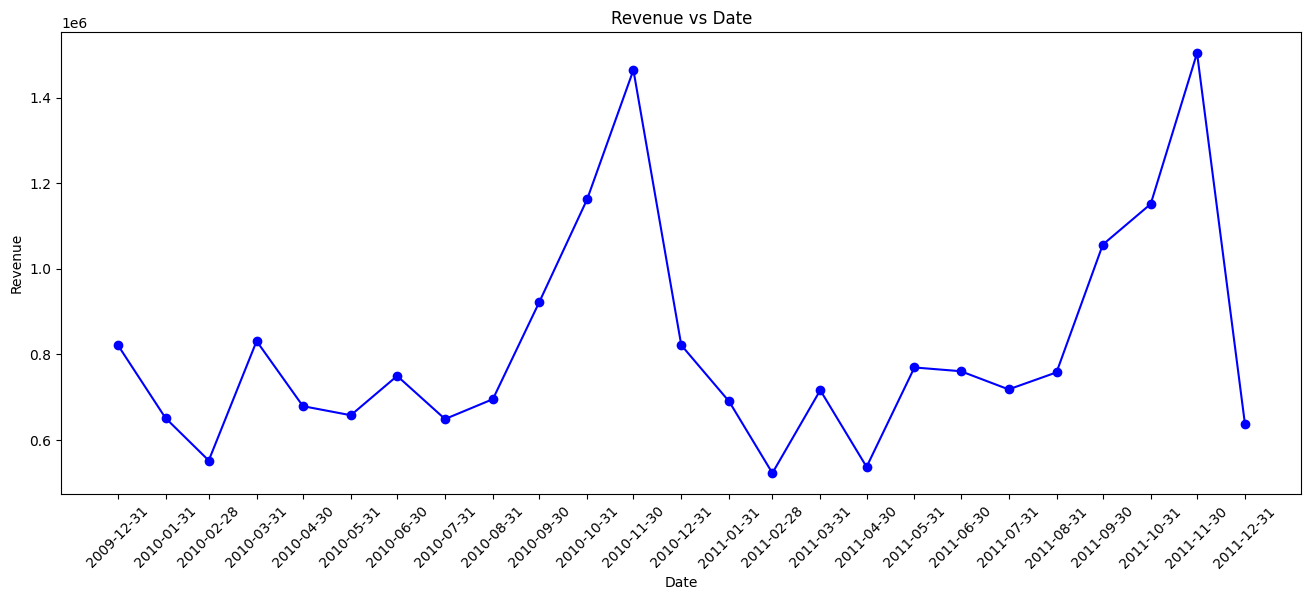

In [206]:
# A line chart of Revenue vs Date
monthly_revenue = data_df.resample('1ME', on='InvoiceDate')["InvoiceAmount"].sum()

plt.figure(figsize=(16, 6))
plt.plot(monthly_revenue.index, monthly_revenue.values, linestyle='-', marker ='o', color='blue')

plt.title("Revenue vs Date")

plt.xlabel("Date")
plt.ylabel("Revenue")
# plt.figure(figsize=(10, 10)) ==> This line is useless, I have to replace it before calling plt.plot()

# Force every date to appear on the x-axis
plt.xticks(ticks=monthly_revenue.index, labels=monthly_revenue.index.strftime('%Y-%m-%d'), rotation=45)

plt.show();



# Time-series analysis.
# df.resample()
# plt.xticks()

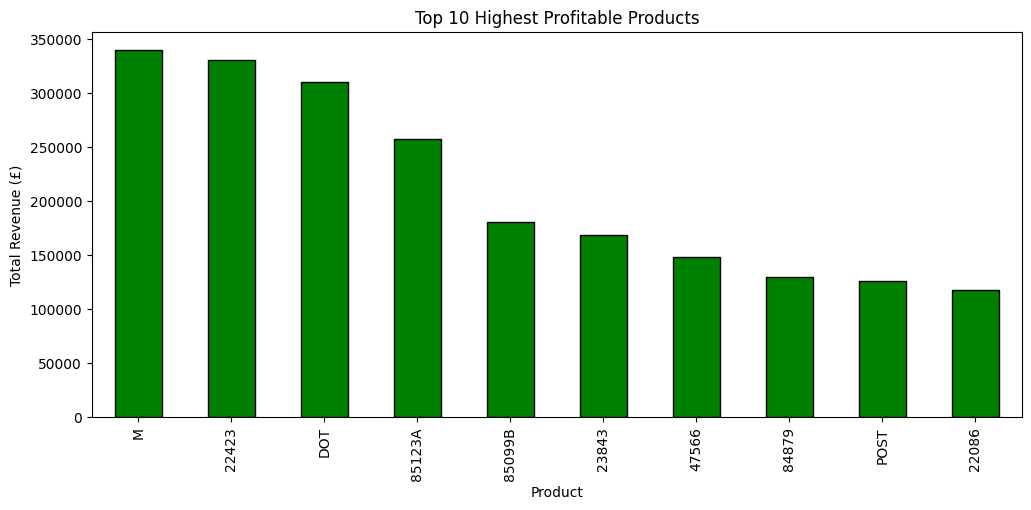

In [207]:
# Top Profitable Items: (StockCode vs Total_Revenue)
top_products = data_df.groupby("StockCode")["InvoiceAmount"].sum().sort_values(ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(12,5))
top_products.plot(kind="bar", color="green", edgecolor="black")

# Labels and title
plt.xlabel("Product")
plt.ylabel("Total Revenue (£)")
plt.title("Top 10 Highest Profitable Products")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.show()

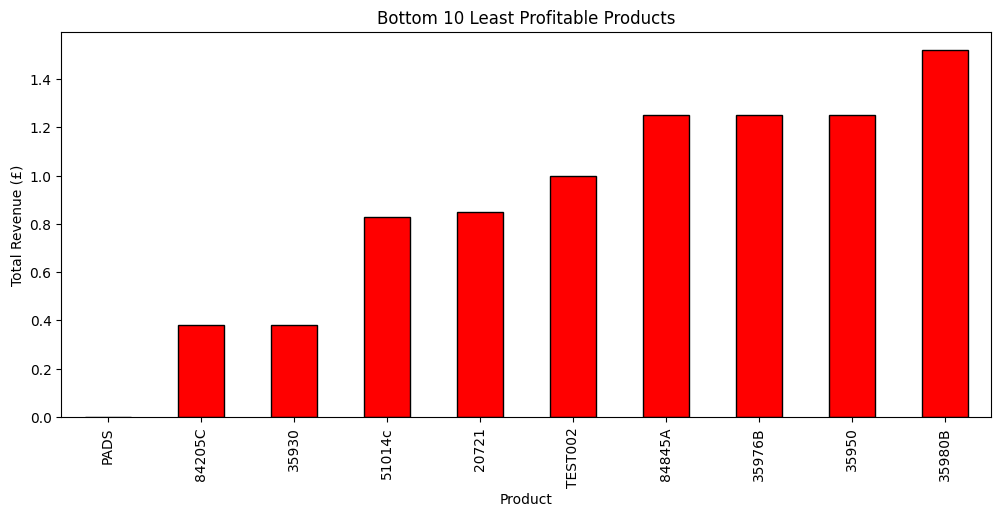

In [208]:
# Least Profitable Items:
worst_products = data_df.groupby("StockCode")["InvoiceAmount"].sum().sort_values(ascending=True).head(10)

plt.figure(figsize=(12,5))
worst_products.plot(kind="bar", color="red", edgecolor="black")

plt.xlabel("Product")
plt.ylabel("Total Revenue (£)")
plt.title("Bottom 10 Least Profitable Products")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.show()
# These low-revenue products might need discounts, better marketing, or discontinuation.
# Could be seasonal (e.g., winter items sell poorly in summer).
# Helps businesses optimize inventory and focus on better-performing products

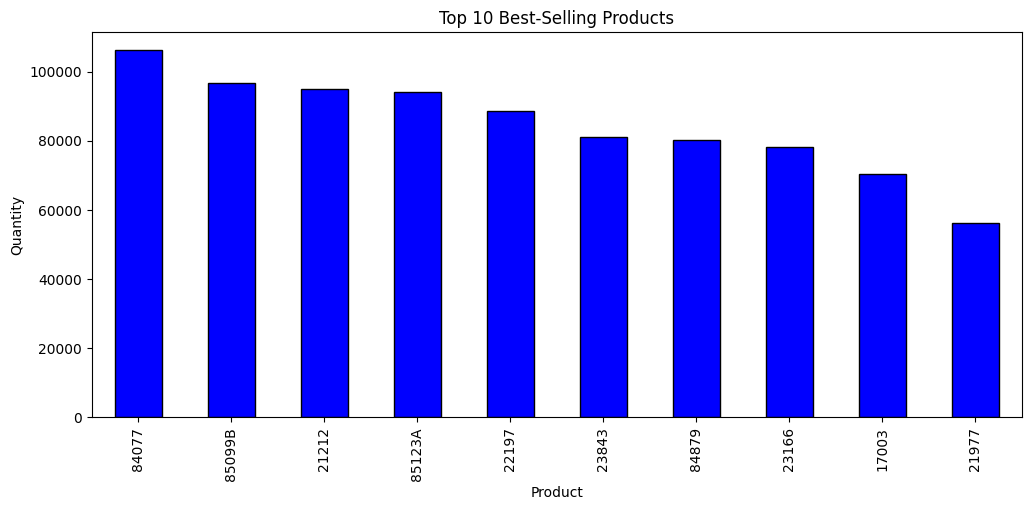

In [209]:
# Best-Selling Items: (StockCode vs Total_Revenue)
best_selling = data_df.groupby("StockCode")["Quantity"].sum().sort_values(ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(12,5))
best_selling.plot(kind="bar", color="blue", edgecolor="black")

# Labels and title
plt.xlabel("Product")
plt.ylabel("Quantity")
plt.title("Top 10 Best-Selling Products")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.show()

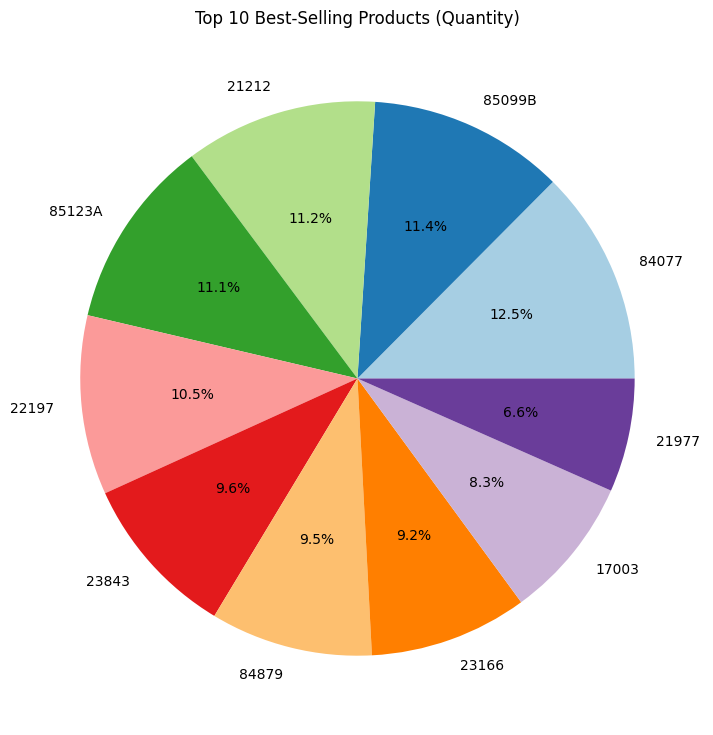

In [210]:
# Calculate total quantity sold per product
top_products = data_df.groupby("StockCode")["Quantity"].sum().nlargest(10)

# Plot Pie Chart
plt.figure(figsize=(12, 9))
plt.pie(top_products, labels=top_products.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title("Top 10 Best-Selling Products (Quantity)")
plt.show()

As we can see, the most sold item isn't the highest profitable one. It's not even in the list of top 10 profitable items.

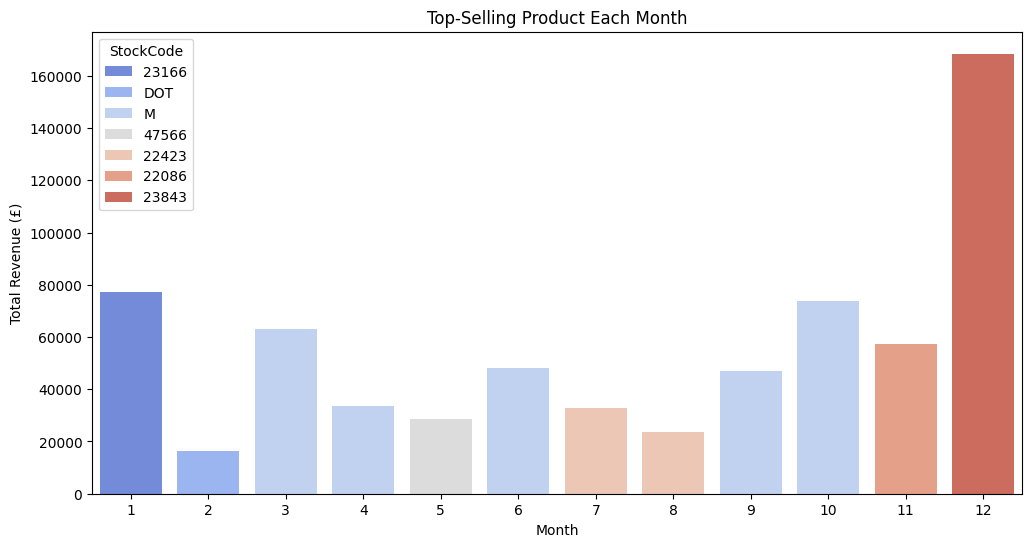

In [211]:
# Top profitable item of each month:
data_df["Month"] = data_df["InvoiceDate"].dt.month

# Group by month and product to find best-selling products each month
monthly_sales = data_df.groupby(["Month", "StockCode"])["InvoiceAmount"].sum().reset_index()
top_monthly_products = monthly_sales.loc[monthly_sales.groupby("Month")["InvoiceAmount"].idxmax()]

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x="Month", y="InvoiceAmount", hue="StockCode", data=top_monthly_products, palette="coolwarm")
plt.xlabel("Month")
plt.ylabel("Total Revenue (£)")
plt.title("Top-Selling Product Each Month")

plt.show()

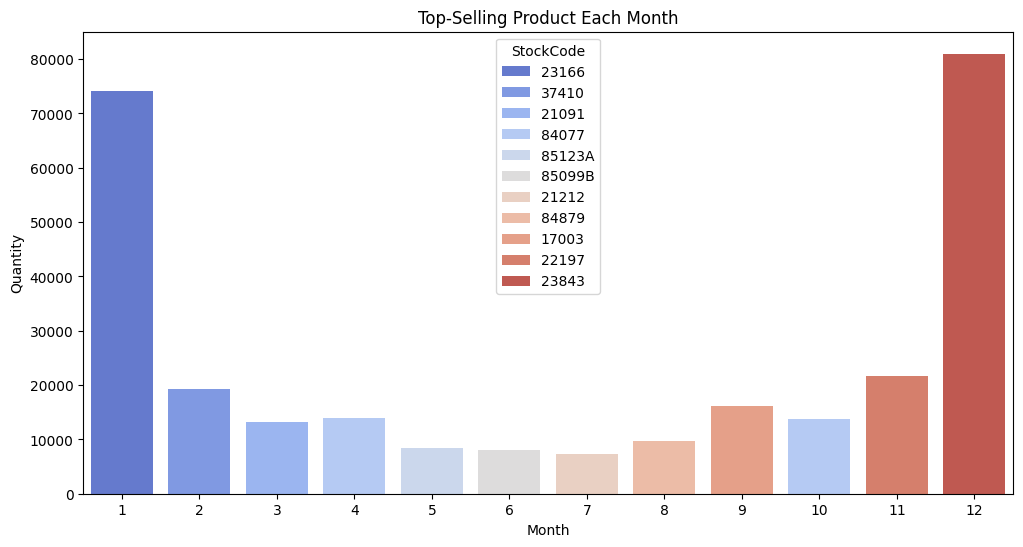

In [212]:
# Top-selling item of each month:
data_df["Month"] = data_df["InvoiceDate"].dt.month

# Group by month and product to find best-selling products each month
monthly_sales = data_df.groupby(["Month", "StockCode"])["Quantity"].sum().reset_index()
top_monthly_products = monthly_sales.loc[monthly_sales.groupby("Month")["Quantity"].idxmax()]

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x="Month", y="Quantity", hue="StockCode", data=top_monthly_products, palette="coolwarm")
plt.xlabel("Month")
plt.ylabel("Quantity")
plt.title("Top-Selling Product Each Month")

plt.show()

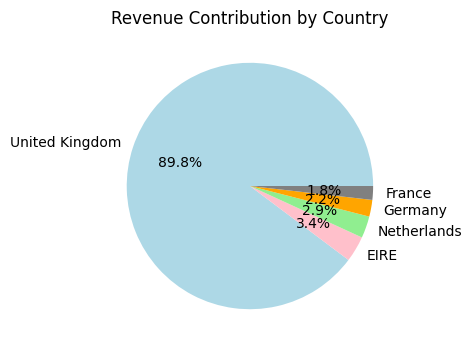

In [213]:
# Top countries involved:
top_countries = data_df.groupby("Country")["InvoiceAmount"].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(4,4))
plt.pie(top_countries, labels=top_countries.index, autopct="%1.1f%%", colors=["#ADD8E6", "pink", "lightgreen", "orange", "gray"])
plt.title("Revenue Contribution by Country")
plt.show()
#Identifies the top markets for sales.

Does lower unit-price means more sales?

Let's check it out

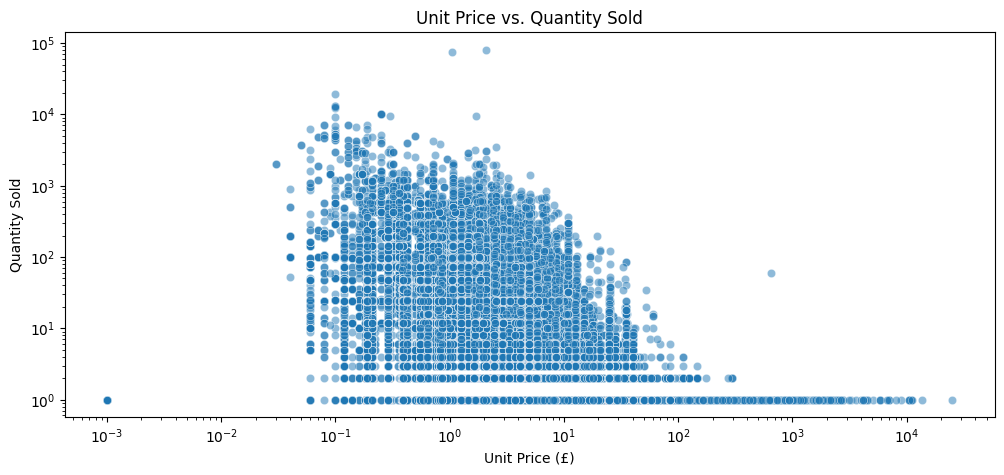

Correlation Coefficient (r): -0.003855923145584454


In [214]:
# A scatter plot to check the relationship between unit-price and sold quantity
plt.figure(figsize=(12,5))
sns.scatterplot(data=data_df, x="UnitPrice", y="Quantity", alpha=0.5)  # alpha=0.5 for transparency to handle overlapping points.

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Unit Price (£)")
plt.ylabel("Quantity Sold")
plt.title("Unit Price vs. Quantity Sold")
plt.show()
# Checks if low prices lead to higher sales.

r_value = data_df["UnitPrice"].corr(data_df["Quantity"])
print(f"Correlation Coefficient (r): {r_value}")

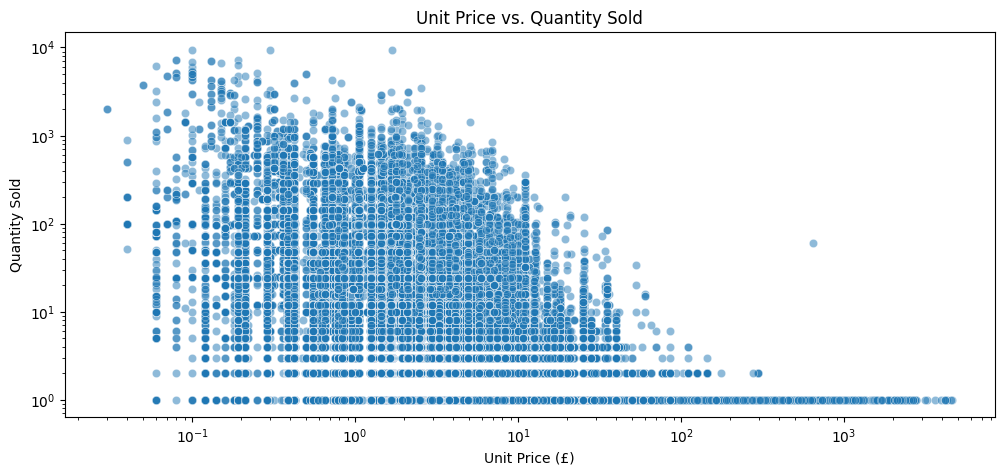

Correlation Coefficient (r): -0.003855923145584454


In [215]:
# Removing extreme values to get a representative correlation coefficient value
df_filtered = data_df[(data_df["UnitPrice"] < 5000) & (data_df["Quantity"] < 10000) & (data_df["UnitPrice"]>0.001)]

plt.figure(figsize=(12,5))
sns.scatterplot(data=df_filtered, x="UnitPrice", y="Quantity", alpha=0.5)  # alpha=0.5 for transparency to handle overlapping points.

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Unit Price (£)")
plt.ylabel("Quantity Sold")
plt.title("Unit Price vs. Quantity Sold")
plt.show()
# Checks if low prices lead to higher sales.

r_value = data_df["UnitPrice"].corr(data_df["Quantity"])
print(f"Correlation Coefficient (r): {r_value}")

So it's almost the same value which is an extremely minimal, negligible inverse relationship.

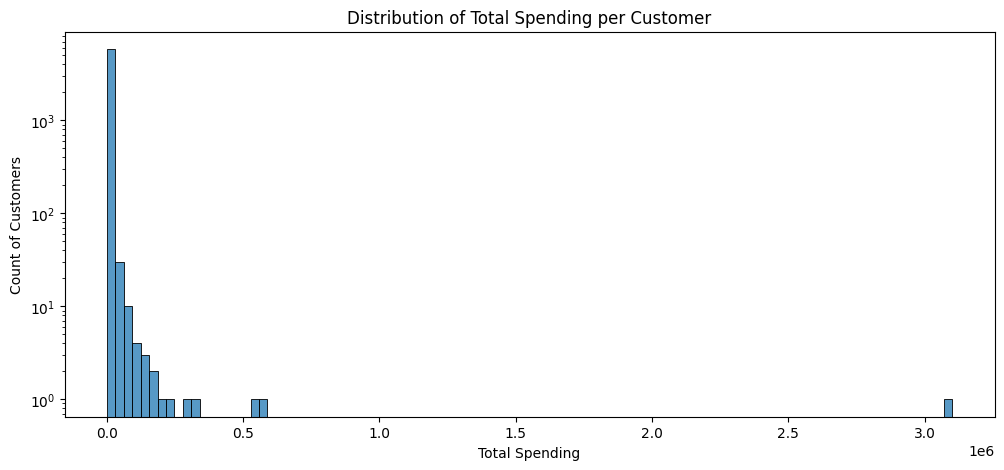

In [216]:
# Top customers
plt.figure(figsize=(12, 5))

customer_purchases = data_df.groupby("CustomerID")["InvoiceAmount"].sum()

# Plot the distribution
sns.histplot(customer_purchases, bins=100, kde=False)

plt.xlabel("Total Spending")
plt.xscale("linear")
plt.yscale("log")
plt.ylabel("Count of Customers")
plt.title("Distribution of Total Spending per Customer")
plt.show()

Number of removed customers before replotting: 1


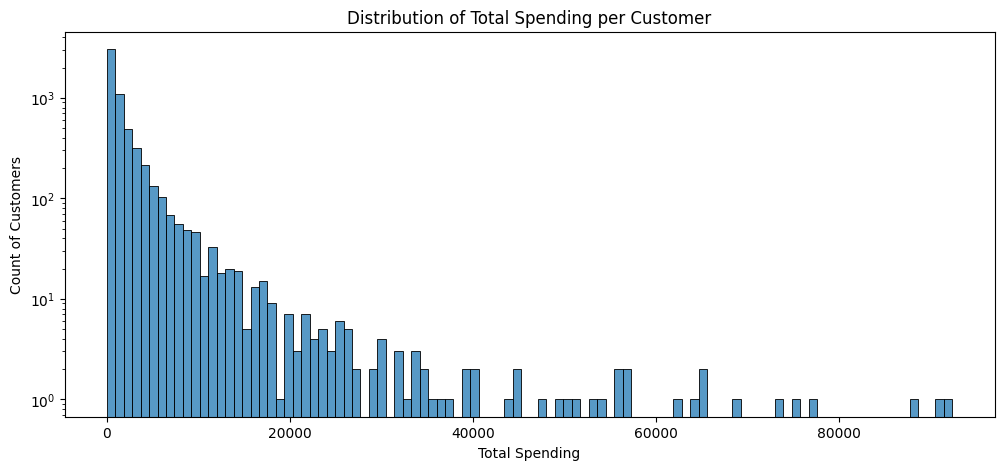

In [217]:
# After removing the customers that spent more than 3 Million:
print(f"Number of removed customers before replotting: {customer_purchases[customer_purchases > 3_000_000].size}")

filtered_purchases = customer_purchases[customer_purchases < 1_00_000]

plt.figure(figsize=(12, 5))
sns.histplot(filtered_purchases, bins=100, kde=False)

plt.xlabel("Total Spending")
plt.xscale("linear")
plt.yscale("log")
plt.ylabel("Count of Customers")
plt.title("Distribution of Total Spending per Customer")
plt.show()

# Note how this graph is more clean and representative

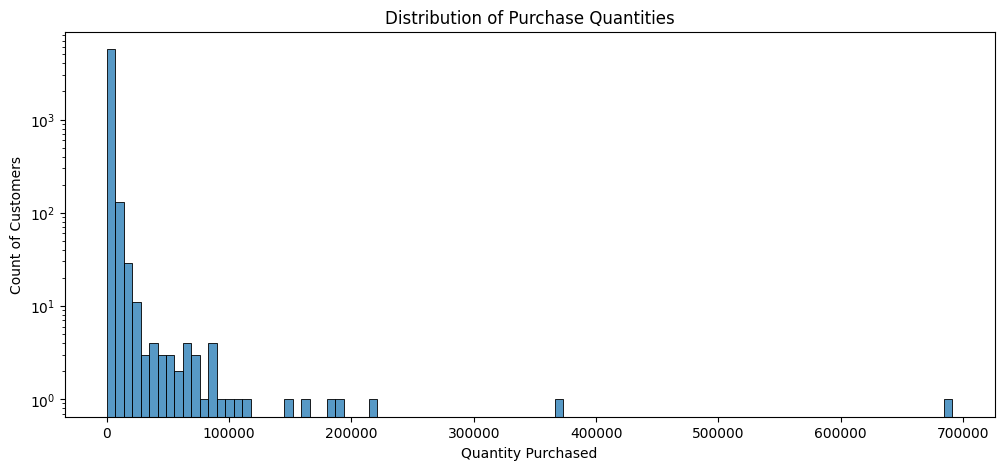

In [218]:
# Customers that bought the most amount of items:
customer_purchases_amnt = data_df.groupby("CustomerID")["Quantity"].sum()

plt.figure(figsize=(12, 5))
# Plot the distribution
sns.histplot(customer_purchases_amnt, bins=100, kde=False)
plt.xscale("linear")
plt.yscale("log")
plt.ylabel("Count of Customers")
plt.xlabel("Quantity Purchased")
plt.title("Distribution of Purchase Quantities")
plt.show()

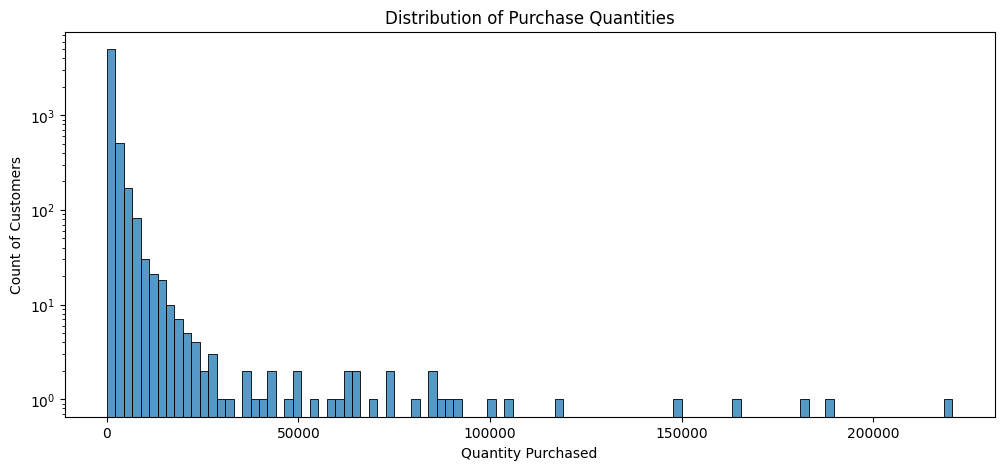

In [219]:
# After removing quantities more than 300k items (only 2 customers removed)
filtered_purchases_amnt = customer_purchases_amnt[customer_purchases_amnt < 3_00_000]

plt.figure(figsize=(12, 5))
# Plot the distribution
sns.histplot(filtered_purchases_amnt, bins=100, kde=False)
plt.xscale("linear")
plt.yscale("log")
plt.ylabel("Count of Customers")
plt.xlabel("Quantity Purchased")
plt.title("Distribution of Purchase Quantities")
plt.show()

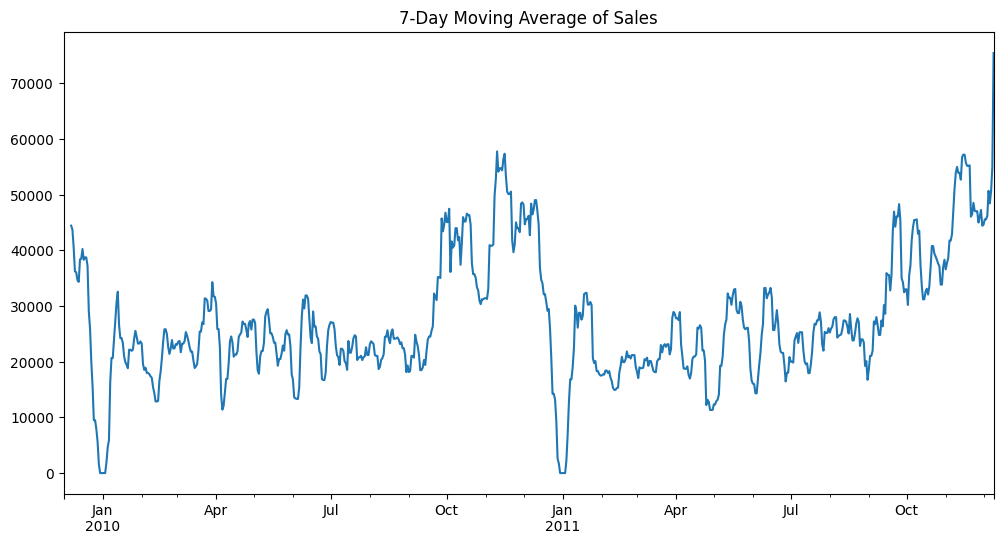

In [222]:
# Moving Average

# Group by date and sum InvoiceAmount for each day
daily_sales = data_df.groupby("InvoiceDate")["InvoiceAmount"].sum()

# Reindex to include all dates between min and max, filling missing days with 0 sales
daily_sales = daily_sales.reindex(pd.date_range(start=daily_sales.index.min(),
                                                end=daily_sales.index.max(),
                                                freq='D'), fill_value=0)

daily_sales.rolling(window=7).mean().plot(figsize=(12, 6), title="7-Day Moving Average of Sales")
plt.show()

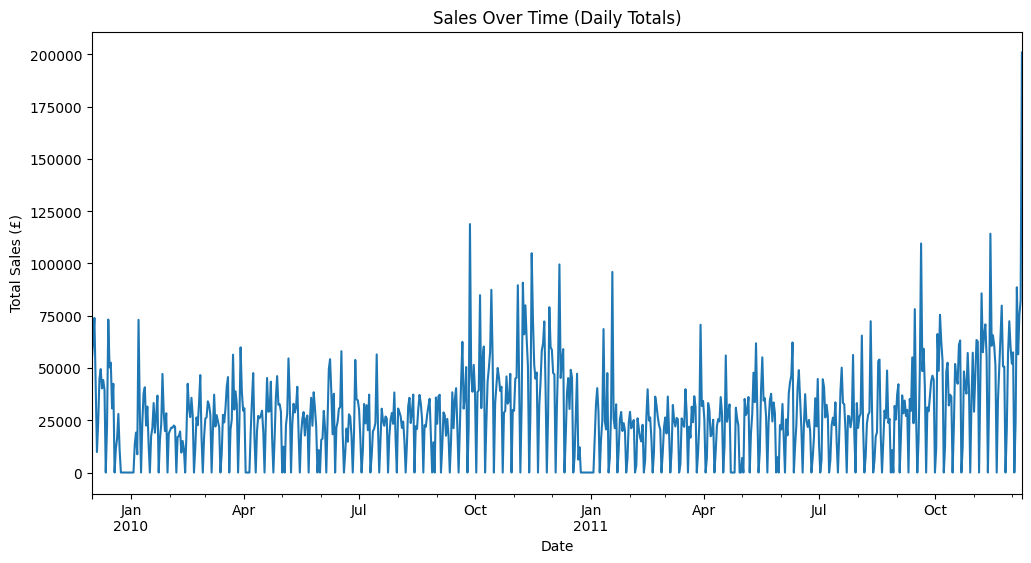

In [223]:
# Seasonal Trend Analysis:
daily_sales.plot(figsize=(12, 6), title="Sales Over Time (Daily Totals)")
plt.xlabel("Date")
plt.ylabel("Total Sales (£)")
plt.show()

# Seasonal Trends Analysis

Decomposes sales data into Trend, Seasonality, and Residuals. Useful for understanding how demand fluctuates over time.

In [228]:
daily_sales.head(100)

,InvoiceAmount
2009-12-01,54351.23
2009-12-02,63172.58
2009-12-03,73972.45
2009-12-04,40582.32
2009-12-05,9803.05
...,...
2010-03-06,0.00
2010-03-07,19805.55
2010-03-08,37254.31
2010-03-09,21999.60


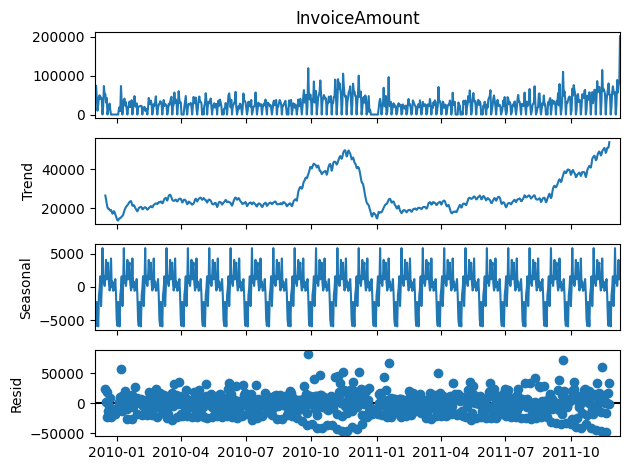

In [225]:
# Decompose daily sales with a 30-day period (adjust as needed)
decomposed = seasonal_decompose(daily_sales, model='additive', period=30)

# Plot decomposition
decomposed.plot()
plt.show()

Let's show which months/days have higher demand.

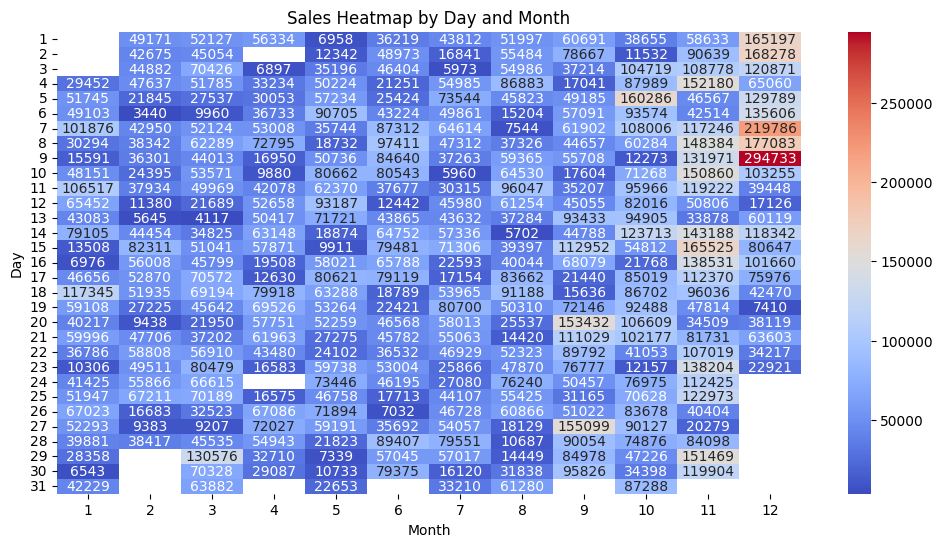

In [229]:
data_df["Day"] = data_df["InvoiceDate"].dt.day
pivot_table = data_df.pivot_table(values='InvoiceAmount', index='Day', columns='Month', aggfunc='sum')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".0f")
plt.title("Sales Heatmap by Day and Month")
plt.show()

Feature Correlation Heatmap

Identifies relationships between variables (e.g., promotions, holidays, weather).

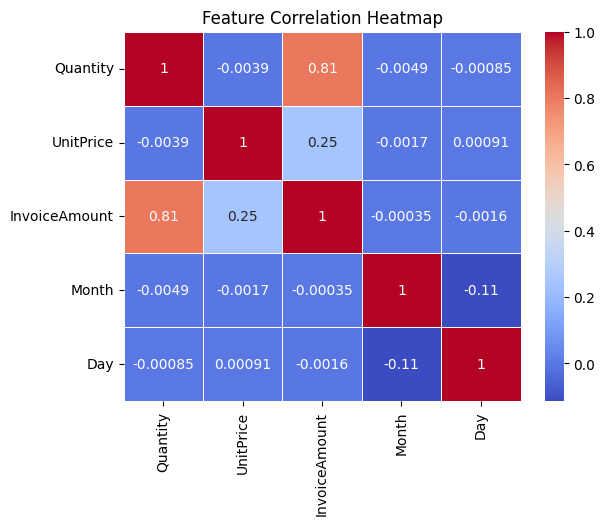

In [230]:
# Calculate correlations only for numeric columns
corr = data_df.select_dtypes(include=['number']).corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

Sales Distribution

Helps detect anomalies in sales data.

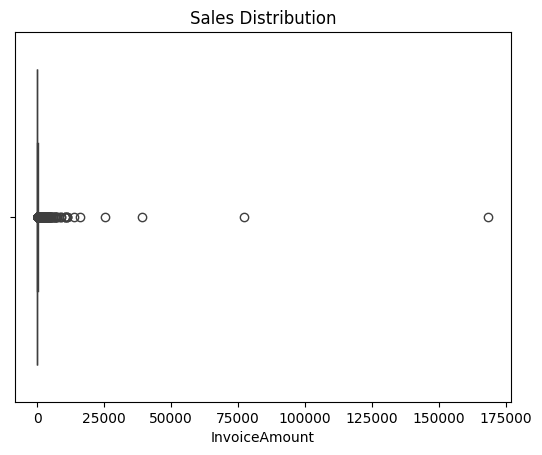

In [231]:
sns.boxplot(x=data_df['InvoiceAmount'])
plt.title("Sales Distribution")
plt.show()